# FloPy MODPATH6 example

This notebook demonstrates forward and backward tracking with MODPATH. The notebook also shows how to create subsets of pathline and endpoint information, plot MODPATH results on ModelMap objects, and export endpoints and pathlines as shapefiles.

In [1]:
import sys
import shutil
import os
import glob
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy version: 1.23.1
matplotlib version: 3.5.3
pandas version: 1.4.3
flopy version: 3.3.6


Load the MODFLOW model, then switch to a temporary working directory.

In [2]:
from pathlib import Path

# temporary directory
temp_dir = TemporaryDirectory()
model_ws = temp_dir.name

model_path = Path(os.getcwd()).parent / "data" / "mp6"
mffiles = list(model_path.glob("EXAMPLE.*"))

m = flopy.modflow.Modflow.load("EXAMPLE.nam", model_ws=model_path)

hdsfile = flopy.utils.HeadFile(os.path.join(model_path, "EXAMPLE.HED"))
hdsfile.get_kstpkper()

hds = hdsfile.get_data(kstpkper=(0, 2))

Plot RIV bc and head results.

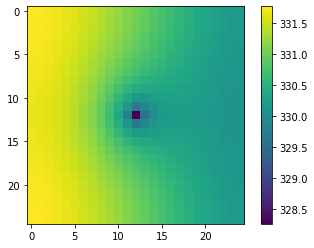

In [3]:
plt.imshow(hds[4, :, :])
plt.colorbar();

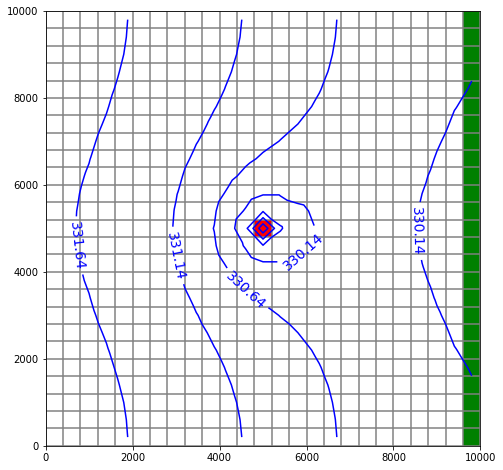

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m, layer=4)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()
riv = mapview.plot_bc("RIV", color="g", plotAll=True)
quadmesh = mapview.plot_bc("WEL", kper=1, plotAll=True)
contour_set = mapview.contour_array(
    hds, levels=np.arange(np.min(hds), np.max(hds), 0.5), colors="b"
)
plt.clabel(contour_set, inline=1, fontsize=14);

Now create forward particle tracking simulation where particles are released at the top of each cell in layer 1:
* specifying the recharge package in ```create_mpsim``` releases a single particle on iface=6 of each top cell  
* start the particles at begining of per 3, step 1, as in example 3 in MODPATH6 manual

**Note:** in FloPy version 3.3.5 and previous, the `Modpath6` constructor `dis_file`, `head_file` and `budget_file` arguments expected filenames relative to the model workspace. In 3.3.6 and later, full paths must be provided &mdash; if they are not, discretization, head and budget data are read directly from the model, as before.

In [5]:
from os.path import join

mp = flopy.modpath.Modpath6(
    modelname="ex6",
    exe_name="mp6",
    modflowmodel=m,
    model_ws=str(model_path),
)

mpb = flopy.modpath.Modpath6Bas(
    mp, hdry=m.lpf.hdry, laytyp=m.lpf.laytyp, ibound=1, prsity=0.1
)

# start the particles at begining of per 3, step 1, as in example 3 in MODPATH6 manual
# (otherwise particles will all go to river)
sim = mp.create_mpsim(
    trackdir="forward",
    simtype="pathline",
    packages="RCH",
    start_time=(2, 0, 1.0),
)

shutil.copy(model_path / "EXAMPLE.DIS", join(model_ws, "EXAMPLE.DIS"))
shutil.copy(model_path / "EXAMPLE.HED", join(model_ws, "EXAMPLE.HED"))
shutil.copy(model_path / "EXAMPLE.BUD", join(model_ws, "EXAMPLE.BUD"))

mp.change_model_ws(model_ws)
mp.write_name_file()
mp.write_input()
mp.run_model(silent=True)

(True, [])

Read in the endpoint file and plot particles that terminated in the well.

In [6]:
fpth = os.path.join(model_ws, "ex6.mpend")
epobj = flopy.utils.EndpointFile(fpth)
well_epd = epobj.get_destination_endpoint_data(dest_cells=[(4, 12, 12)])
# returns record array of same form as epobj.get_all_data()

In [7]:
well_epd[0:2]

rec.array([(50, 0, 2, 0., 29565.62, 1, 0, 2, 0, 6, 0, 0.5, 0.5, 1., 200., 9000., 339.1231, 1, 4, 12, 12, 2, 0, 1.       , 0.9178849, 0.09755219, 5200.   , 5167.154,  9.755219, b'rch'),
           (75, 0, 2, 0., 26106.59, 1, 0, 3, 0, 6, 0, 0.5, 0.5, 1., 200., 8600., 339.1203, 1, 4, 12, 12, 4, 0, 0.7848778, 1.       , 0.1387314 , 5113.951, 5200.   , 13.87314 , b'rch')],
          dtype=[('particleid', '<i4'), ('particlegroup', '<i4'), ('status', '<i4'), ('time0', '<f4'), ('time', '<f4'), ('initialgrid', '<i4'), ('k0', '<i4'), ('i0', '<i4'), ('j0', '<i4'), ('cellface0', '<i4'), ('zone0', '<i4'), ('xloc0', '<f4'), ('yloc0', '<f4'), ('zloc0', '<f4'), ('x0', '<f4'), ('y0', '<f4'), ('z0', '<f4'), ('finalgrid', '<i4'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('cellface', '<i4'), ('zone', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('label', 'O')])

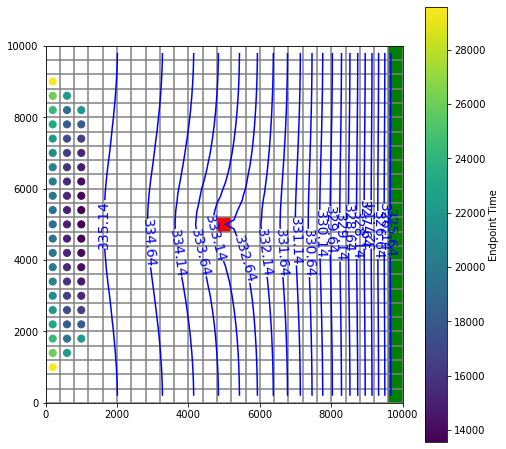

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m, layer=2)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()
riv = mapview.plot_bc("RIV", color="g", plotAll=True)
quadmesh = mapview.plot_bc("WEL", kper=1, plotAll=True)
contour_set = mapview.contour_array(
    hds, levels=np.arange(np.min(hds), np.max(hds), 0.5), colors="b"
)
plt.clabel(contour_set, inline=1, fontsize=14)
mapview.plot_endpoint(well_epd, direction="starting", colorbar=True);

Write starting locations to a shapefile.

In [9]:
fpth = os.path.join(model_ws, "starting_locs.shp")
print(type(fpth))
epobj.write_shapefile(
    well_epd, direction="starting", shpname=fpth, mg=m.modelgrid
)

<class 'str'>
No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.(writing .prj files from proj4 strings not supported)
wrote /var/folders/4t/2sbpjbgs1n73t8s7rx4gb_ph0000gn/T/tmpxqercxxz/starting_locs.shp


Read in the pathline file and subset to pathlines that terminated in the well  .

In [10]:
# make a selection of cells that terminate in the well cell = (4, 12, 12)
pthobj = flopy.utils.PathlineFile(os.path.join(model_ws, "ex6.mppth"))
well_pathlines = pthobj.get_destination_pathline_data(dest_cells=[(4, 12, 12)])

Plot the pathlines that terminate in the well and the starting locations of the particles.

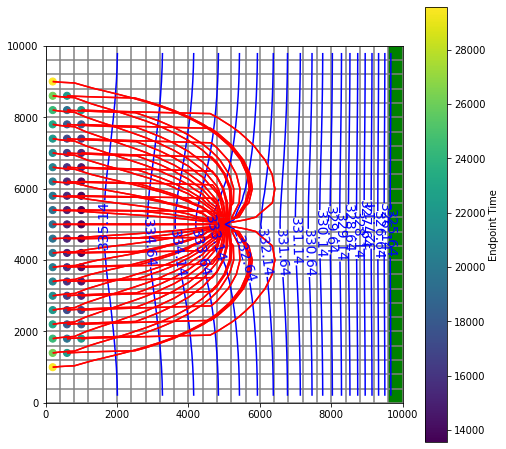

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m, layer=2)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()
riv = mapview.plot_bc("RIV", color="g", plotAll=True)
quadmesh = mapview.plot_bc("WEL", kper=1, plotAll=True)
contour_set = mapview.contour_array(
    hds, levels=np.arange(np.min(hds), np.max(hds), 0.5), colors="b"
)
plt.clabel(contour_set, inline=1, fontsize=14)

mapview.plot_endpoint(well_epd, direction="starting", colorbar=True)
# for now, each particle must be plotted individually
# (plot_pathline() will plot a single line for recarray with multiple particles)
# for pid in np.unique(well_pathlines.particleid):
#   modelmap.plot_pathline(pthobj.get_data(pid), layer='all', colors='red');
mapview.plot_pathline(well_pathlines, layer="all", colors="red");

Write pathlines to a shapefile.

In [12]:
# one line feature per particle
pthobj.write_shapefile(
    well_pathlines,
    direction="starting",
    shpname=os.path.join(model_ws, "pathlines.shp"),
    mg=m.modelgrid,
)

# one line feature for each row in pathline file
# (can be used to color lines by time or layer in a GIS)
pthobj.write_shapefile(
    well_pathlines,
    one_per_particle=False,
    shpname=os.path.join(model_ws, "pathlines_1per.shp"),
    mg=m.modelgrid,
)

(numpy.record, {'names': ['x', 'y', 'z', 'time', 'k', 'particleid'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<i4', '<i4'], 'offsets': [20, 24, 28, 16, 32, 0], 'itemsize': 64})
No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.(writing .prj files from proj4 strings not supported)
wrote /var/folders/4t/2sbpjbgs1n73t8s7rx4gb_ph0000gn/T/tmpxqercxxz/pathlines.shp
(numpy.record, {'names': ['x', 'y', 'z', 'time', 'k', 'particleid'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<i4', '<i4'], 'offsets': [20, 24, 28, 16, 32, 0], 'itemsize': 64})
No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.(writing .prj files from proj4 strings not supported)
wrote /var/folders/4t/2sbpjbgs1n73t8s7rx4gb_ph0000gn/T/tmpxqercxxz/pathlines_1per.shp


Replace WEL package with MNW2, and create backward tracking simulation using particles released at MNW well.

In [13]:
m2 = flopy.modflow.Modflow.load(
    "EXAMPLE.nam", model_ws=str(model_path), exe_name="mf2005"
)
m2.get_package_list()

['DIS', 'BAS6', 'WEL', 'RIV', 'RCH', 'OC', 'PCG', 'LPF']

In [14]:
m2.nrow_ncol_nlay_nper

(25, 25, 5, 3)

In [15]:
m2.wel.stress_period_data.data

{0: 0,
 1: rec.array([(4, 12, 12, -150000., 0.)],
           dtype=[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('flux', '<f4'), ('iface', '<f4')]),
 2: rec.array([(4, 12, 12, -150000., 0.)],
           dtype=[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('flux', '<f4'), ('iface', '<f4')])}

In [16]:
node_data = np.array(
    [
        (3, 12, 12, "well1", "skin", -1, 0, 0, 0, 1.0, 2.0, 5.0, 6.2),
        (4, 12, 12, "well1", "skin", -1, 0, 0, 0, 0.5, 2.0, 5.0, 6.2),
    ],
    dtype=[
        ("k", int),
        ("i", int),
        ("j", int),
        ("wellid", object),
        ("losstype", object),
        ("pumploc", int),
        ("qlimit", int),
        ("ppflag", int),
        ("pumpcap", int),
        ("rw", float),
        ("rskin", float),
        ("kskin", float),
        ("zpump", float),
    ],
).view(np.recarray)

stress_period_data = {
    0: np.array(
        [(0, "well1", -150000.0)],
        dtype=[("per", int), ("wellid", object), ("qdes", float)],
    )
}

In [17]:
m2.name = "Example_mnw"
m2.remove_package("WEL")
mnw2 = flopy.modflow.ModflowMnw2(
    model=m2,
    mnwmax=1,
    node_data=node_data,
    stress_period_data=stress_period_data,
    itmp=[1, -1, -1],
)
m2.get_package_list()

['DIS', 'BAS6', 'RIV', 'RCH', 'OC', 'PCG', 'LPF', 'MNW2']

Write and run MODFLOW.

In [18]:
m2.change_model_ws(model_ws)
m2.write_name_file()
m2.write_input()
m2.run_model(silent=True)

(True, [])

Create a new `Modpath6` object.

In [19]:
mp = flopy.modpath.Modpath6(
    modelname="ex6mnw",
    exe_name="mp6",
    modflowmodel=m2,
    model_ws=model_ws,
)

mpb = flopy.modpath.Modpath6Bas(
    mp, hdry=m2.lpf.hdry, laytyp=m2.lpf.laytyp, ibound=1, prsity=0.1
)
sim = mp.create_mpsim(trackdir="backward", simtype="pathline", packages="MNW2")

mp.change_model_ws(model_ws)
mp.write_name_file()
mp.write_input()
mp.run_model(silent=True)

(True, [])

Read in results and plot.

In [20]:
pthobj = flopy.utils.PathlineFile(os.path.join(model_ws, "ex6mnw.mppth"))
epdobj = flopy.utils.EndpointFile(os.path.join(model_ws, "ex6mnw.mpend"))
well_epd = epdobj.get_alldata()
well_pathlines = (
    pthobj.get_alldata()
)  # returns a list of recarrays; one per pathline

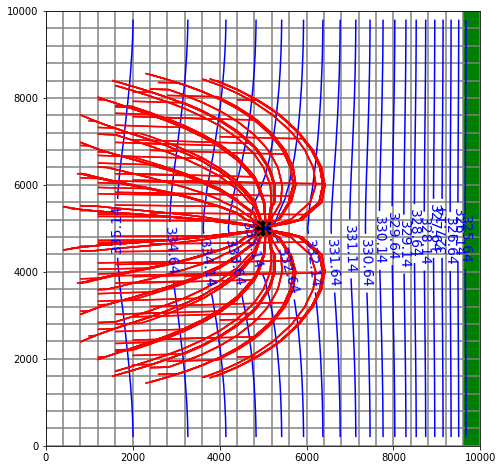

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m2, layer=2)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()
riv = mapview.plot_bc("RIV", color="g", plotAll=True)
quadmesh = mapview.plot_bc("MNW2", kper=1, plotAll=True)
contour_set = mapview.contour_array(
    hds, levels=np.arange(np.min(hds), np.max(hds), 0.5), colors="b"
)
plt.clabel(contour_set, inline=1, fontsize=14)

mapview.plot_pathline(
    well_pathlines, travel_time="<10000", layer="all", colors="red"
);

In [22]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass